In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy as db
from sqlalchemy.engine import URL


In [5]:
connection_url = URL.create("mssql+pyodbc",  query={"odbc_connect": "Driver={SQL Server Native Client 11.0};"
                      "Server=DESKTOP-QG4REIU\SQLEXPRESS;"
                      "Database=WideWorldImporters;"
                      "Trusted_Connection=yes;"
                      'NeedODBCTypesOnly=1;'})
engine = db.create_engine(connection_url)

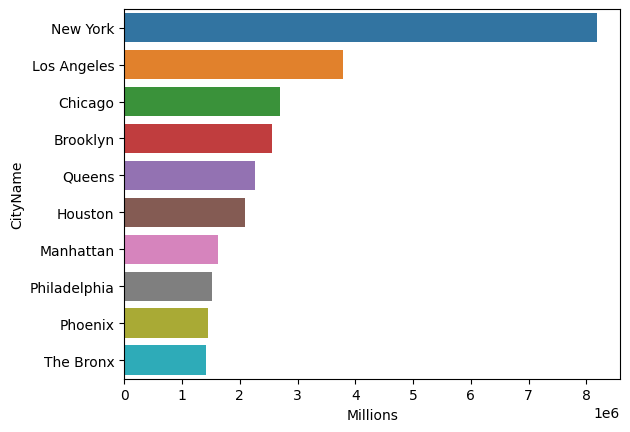

In [6]:
# 1. Visualize the top 10 cities with the highest latest recorded population
sql = """
SELECT TOP 10 CityName, LatestRecordedPopulation 
FROM Application.Cities
ORDER BY LatestRecordedPopulation DESC;
"""

df = pd.read_sql(sql, engine)

fix, ax  = plt.subplots()
sns.barplot(x = df['LatestRecordedPopulation'], y = df['CityName'])
ax.set_xlabel("Millions")
plt.show()


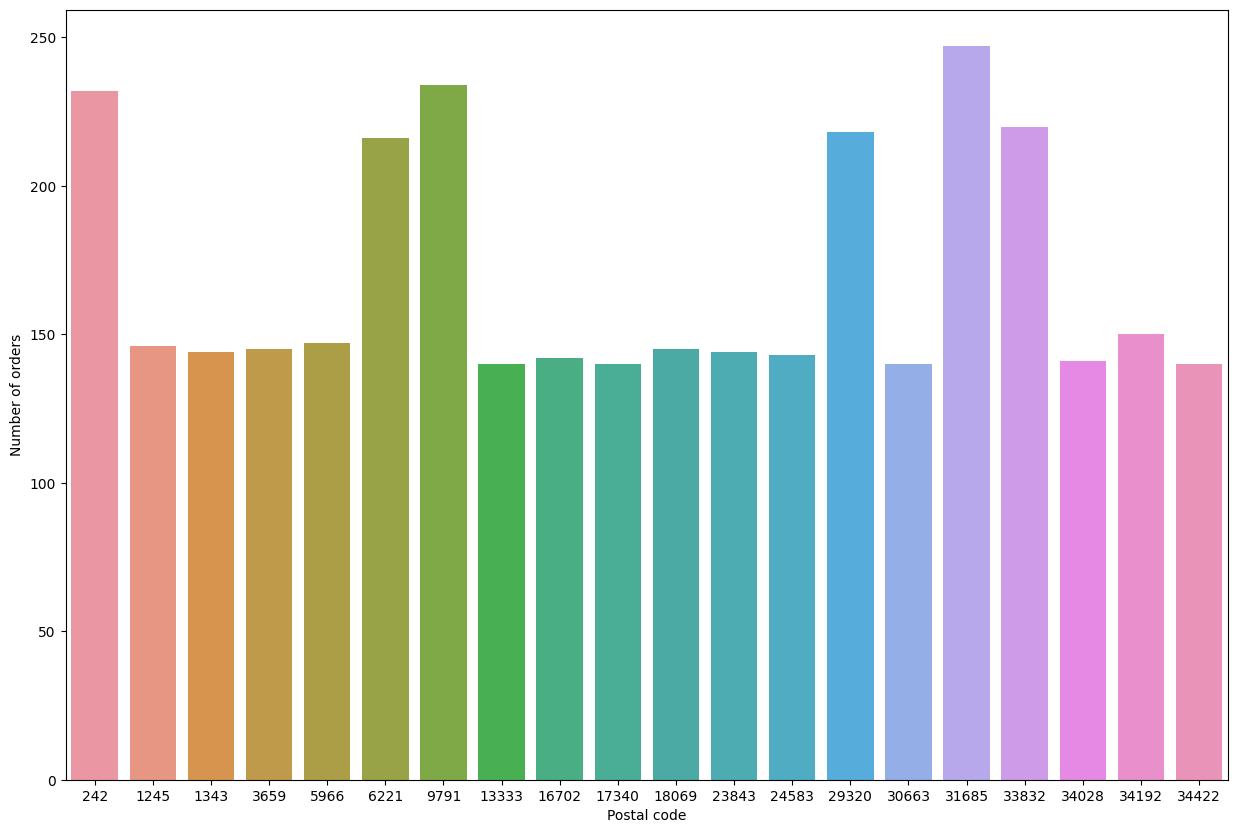

In [8]:
# 2. Visualize the top 20 cities with the highest number of orders made by customers using a bar chart based 
#    on the customer postal city
sql = """
select distinct top 20 count(orderid) over(partition by postalcityid) as 'OrderTotal', postalcityid
from sales.orders as so
    join sales.customers as sc
    on so.customerid = sc.customerid
group by orderid, postalcityid
order by OrderTotal desc;    
"""
df = pd.read_sql(sql, engine)
#print(df)
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
sns.barplot(x = df['postalcityid'], y=df['OrderTotal'])
ax.set_xlabel("Postal code")
ax.set_ylabel("Number of orders")
plt.show()

<AxesSubplot: xlabel='Invoice Amount', ylabel='Count'>

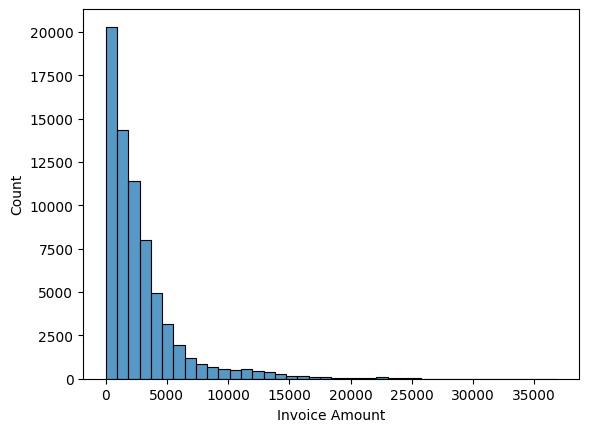

In [9]:
# 3. Make a histogram plot of all invoice total amounts based on the extended price amounts of the invoice lines
sql = """
SELECT SUM(ExtendedPrice) as "Invoice Amount"
FROM Sales.InvoiceLines
GROUP BY InvoiceID
"""
df = pd.read_sql(sql, engine)
sns.histplot(df["Invoice Amount"], bins=40) #I'm not sure why I put 40, but it's a nice number and I think it looks just fine

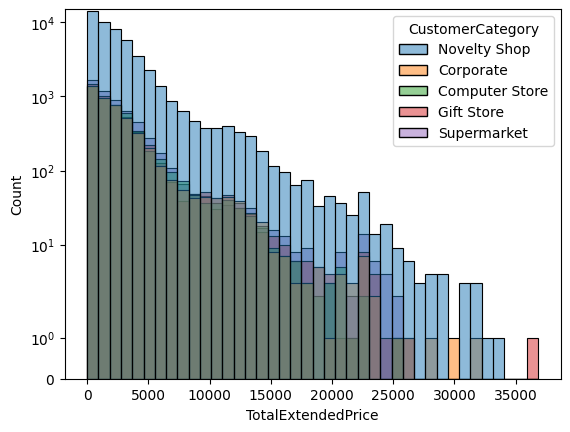

In [26]:
# 4. Make a stacked histogram plot of all invoice total amounts based on the extended price amounts and based on the customer 
#    categories
sql = """
select sum(extendedprice) as 'TotalExtendedPrice', 
scc.CustomerCategoryName as "CustomerCategory"
from sales.InvoiceLines as sil
join sales.Invoices as si
on sil.InvoiceID = si.InvoiceID
join sales.Customers as sc
on sc.CustomerID = si.CustomerID
join sales.CustomerCategories as scc 
on scc.CustomerCategoryID = sc.CustomerCategoryID
group by scc.CustomerCategoryName, sil.InvoiceID
"""
df = pd.read_sql(sql, engine)
fig, ax = plt.subplots()
sns.histplot(x=df['TotalExtendedPrice'], hue=df['CustomerCategory'], bins=40).set_yscale("symlog")
#I tried using set_yscale to better show off the data I suppose
plt.show()




<AxesSubplot: xlabel='year', ylabel='month'>

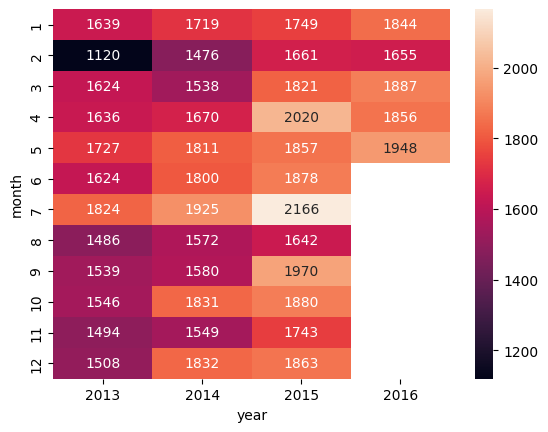

In [28]:
# 5. Make an annotated heatmap which visualizes the number of invoices per month and year
sql = """
select month(invoicedate) as 'month', year(invoicedate) as 'year', count(invoiceid) as 'CountOfInvoices'
from sales.Invoices
group by month(invoicedate), year(invoicedate)
order by month(invoicedate) asc, year(invoicedate) asc
"""
df = pd.read_sql(sql, engine)
fig, ax = plt.subplots()
df = df.pivot(index = "month", columns = "year", values="CountOfInvoices")
sns.heatmap(df, annot=True, fmt="4.0f")



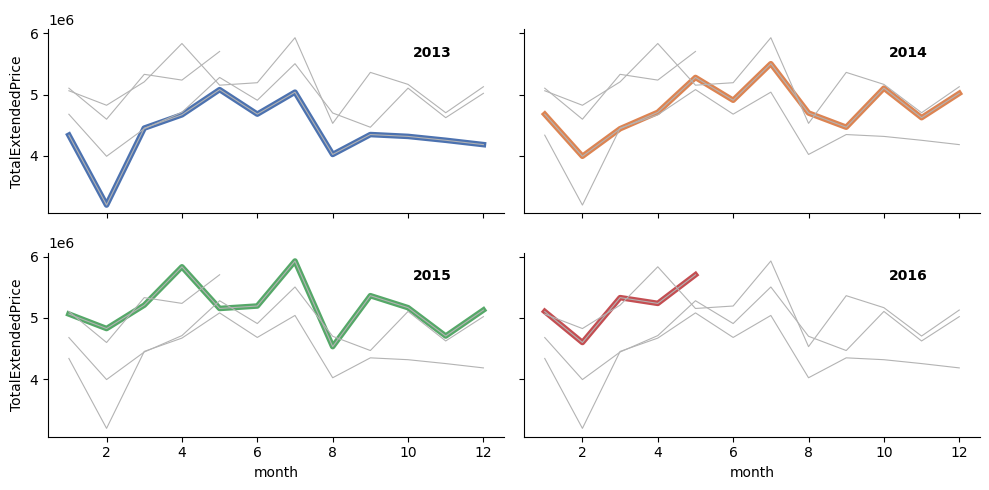

In [54]:
# 6. Make a small multiple time series plot where you plot the total invoice amounts per month for several 
#    consecutive years between 2013 and 2016. 

sql = """
select year(invoicedate) as 'year', month(invoicedate) as 'month',
sum(extendedprice) as 'TotalExtendedPrice'
from sales.Invoices as si
join sales.InvoiceLines as sil
on sil.InvoiceID = si.InvoiceID
group by year(invoicedate), month(invoicedate)
order by year(invoicedate) asc, month(invoicedate) asc
"""


df = pd.read_sql(sql, engine)
graphs = sns.relplot(
    data=df,
    x="month", y="TotalExtendedPrice", col="year", hue="year", legend=False,
    kind="line", col_wrap=2, height=2.5, aspect=2, palette="deep", linewidth=4
)
graphs.set_titles(" ")
for year, ax in graphs.axes_dict.items():
    ax.text(.8, .85, year, transform=ax.transAxes, fontweight="bold")
    sns.lineplot(
        data=df, x="month", y="TotalExtendedPrice", units="year",
        estimator=None,linewidth=0.8, ax=ax, color=".7"
    )




<AxesSubplot: xlabel='Total sales', ylabel='CustomerName'>

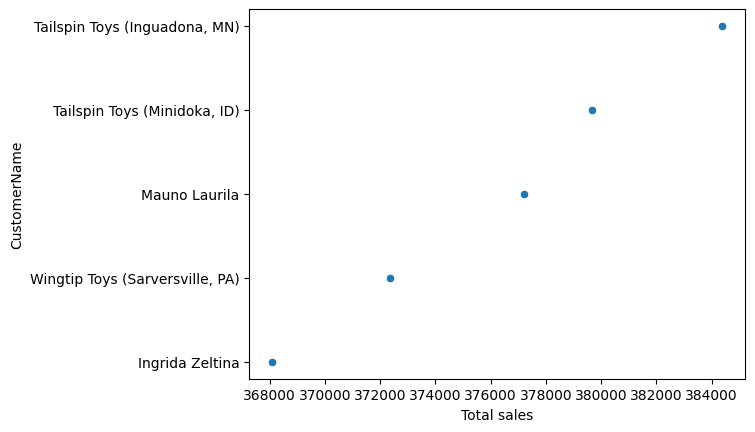

In [64]:
# 7. Create one additional visualization of your choice that is suitable for the data from WWI DB.

#
sql = """
select top(5) CustomerName, sum(sol.Quantity*sol.UnitPrice) as 'Total sales'
from sales.Customers as sc
join sales.Orders as so
on sc.CustomerID = so.CustomerID
join sales.OrderLines as sol
on sol.OrderID = so.OrderID
group by CustomerName
order by [Total sales] desc
"""

df = pd.read_sql(sql, engine)
fig,ax = plt.subplots()
sns.scatterplot(data=df, x="Total sales", y="CustomerName")
#Just wanted to use a scatterplot I guess :D

